In [ ]:
# load, v1 / RGB
import jax
import jax.numpy as jnp
from jax import jit
import jax.random as rnd
import numpy as np
np.set_printoptions(threshold=1000, linewidth=200)
import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
import matplotlib.cm as cm
from matplotlib.patches import Ellipse
import os
import functools

def load_data(str_):
    path_ = os.path.dirname(os.getcwd()) + '/sc_project/test_data/' # Path(__file__).resolve().parents[1]
    with open(path_+str_,'rb') as file_:
        # param = pickle.load(file_)
        param_ = jnp.load(file_,allow_pickle=True)
    return param_

file_ = 'forward_new_v1_225_02_08-0732.pkl' # 'forward_new_v1_225_31_07-0617.pkl' # 'move_loop_v2_data_27_07-160547.pkl' # 'move_loop_v2_data_27_07-161313.pkl'[7] # _'move_loop_v1_26_07-093804.pkl' # move_loop_v1__25_07-161050.pkl
(arrs,aux) = load_data(file_) # # [VMAPS,STEPS,N]x2,[VMAPS,STEPS,2]x3,[VMAPS,STEPS]x2
(loss_arr,loss_sem,loss_v_arr,v_std_arr,loss_r_arr,r_std_arr) = arrs
(v_pred_arr,v_t_arr,loss_v_arr_,loss_d_arr_,pos_arr,dot_arr,rel_vec_hat_arr,opt_state,p_weights) = aux
print('loss_arr.shape=',loss_arr.shape,'loss_sem.shape=',loss_sem.shape,'loss_v_arr.shape=',loss_v_arr.shape,'v_std_arr.shape=',v_std_arr.shape,'loss_r_arr.shape=',loss_r_arr.shape,'r_std_arr.shape=',r_std_arr.shape)
print('v_pred_arr.shape=',v_pred_arr.shape,'v_t_arr.shape=',v_t_arr.shape,'loss_v_arr_.shape=',loss_v_arr_.shape,'loss_d_arr_.shape=',loss_d_arr_.shape,'pos_arr.shape=',pos_arr.shape,'dot_arr.shape=',dot_arr.shape,'rel_vec_hat_arr.shape=',rel_vec_hat_arr.shape)
rel_vec_hat_arr = jnp.concatenate([jnp.nan*jnp.zeros((500,1,2)),rel_vec_hat_arr],axis=1)

In [ ]:
# sort arrs, v1
tot_loss = jnp.sum(loss_v_arr_+loss_d_arr_, axis=1)
loss_tot_asc = jnp.argsort(tot_loss) #[::-1]
tot_loss_v = jnp.sum(loss_v_arr_, axis=1)
loss_v_asc = jnp.argsort(tot_loss_v) #[::-1]
tot_loss_d = jnp.sum(loss_d_arr_, axis=1)
loss_d_asc = jnp.argsort(tot_loss_d) #[::-1]
print('loss_tot_asc=',loss_tot_asc[:10])
print('loss_v_asc=',loss_v_asc[:10])
print('loss_d_asc=',loss_d_asc[:10])

In [ ]:
# full ani, v1
%matplotlib qt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.animation as animation
import functools

def mod_(x):
    return (x + np.pi) % (2 * np.pi) - np.pi

def gen_vectors(MODULES, APERTURE):
    m = MODULES
    A = APERTURE
    x = np.linspace(-(A-A/m), (A-A/m), m)
    x_ = np.tile(x, (m, ))
    y_ = np.repeat(np.flip(x), m)
    return np.vstack([x_, y_])

def set_axis_properties(ax,lim,labels,title=''):
    ax.set_xlim(-lim,lim)
    ax.set_ylim(-lim,lim)
    ax.set_aspect('equal', 'box')  
    ax.set_title(title)
    ticks = np.linspace(-lim,lim,5)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

def get_aperture_points(agent_t,aperture,density=100):
    x_horizontal = np.linspace(agent_t[0] - aperture, agent_t[0] + aperture, density)
    y_top = np.full(density, agent_t[1] + aperture)
    y_bottom = np.full(density, agent_t[1] - aperture)
    y_vertical = np.linspace(agent_t[1] - aperture, agent_t[1] + aperture, density)
    x_left = np.full(density, agent_t[0] - aperture)
    x_right = np.full(density, agent_t[0] + aperture)
    x_tot = np.concatenate([x_left, x_right, x_horizontal, x_horizontal])
    y_tot = np.concatenate([y_vertical, y_vertical, y_bottom, y_top])
    return x_tot, y_tot

def animate(i,v_pred_arr,v_t_arr,dot_arr,dot_hat_arr,pos_arr,dot,dot_hat,agent,neuron_locs,scatters_pred,scatters_t,aperture_points,act_space_points):
    # initialize
    dot.set_data(mod_(dot_arr[i, 0]), mod_(dot_arr[i, 1]))
    agent.set_data(mod_(pos_arr[i, 0]), mod_(pos_arr[i, 1]))
    dot_hat.set_data(mod_(dot_hat_arr[i, 0]), mod_(dot_hat_arr[i, 1]))
    # aperture color
    if i == 0:
        aperture_points.set_color('green')
    else:
        aperture_points.set_color('black')
    # Update v_pred_arr
    scatters_pred.set_offsets(neuron_locs.T)
    scatters_pred.set_array(v_pred_arr[i,:,:].flatten())
    scatters_pred.set_sizes(17 * np.sum(v_pred_arr[i, :, :], axis=0))
    # Update v_t_arr
    scatters_t.set_offsets(neuron_locs.T)
    scatters_t.set_array(v_t_arr[i,:,:].flatten())
    scatters_t.set_sizes(17 * np.sum(v_t_arr[i, :, :], axis=0))
    x_aperture,y_aperture = get_aperture_points(pos_arr[i],APERTURE)
    aperture_points.set_offsets(np.c_[mod_(x_aperture), mod_(y_aperture)])
    x_act_space,y_act_space = get_aperture_points(pos_arr[i],ACT_SPACE)
    act_space_points.set_offsets(np.c_[mod_(x_act_space), mod_(y_act_space)])
    return [dot,agent,dot_hat,scatters_pred,scatters_t,aperture_points,act_space_points]

k = 417 # 20
interval = 300
STEPS = v_pred_arr.shape[1]
MODULES = 15
NEURONS = 10
APERTURE = np.pi/2
ACT_SPACE = np.pi/5

neuron_locs = gen_vectors(NEURONS,ACT_SPACE)
v_pred_arr_ = np.clip(v_pred_arr[k,:,:],0,1).reshape((STEPS,3,NEURONS**2)) #.transpose(0, 2, 1)
v_t_arr_ = v_t_arr[k,:,:].reshape((STEPS,3,NEURONS**2)) #.transpose(0, 2, 1)
dot_arr_ = dot_arr[k,:,:].T # [STEPS,2]
pos_arr_ = pos_arr[k,:,:].T # [STEPS,2]
rel_vec_hat_arr_ = rel_vec_hat_arr[k,:,:] # [STEPS,2]
dot_hat_arr_ = mod_(rel_vec_hat_arr_ + pos_arr_)

fig = plt.figure(figsize=(8, 12))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1])

ax_ani = plt.subplot(gs[0:2, 0:2],aspect='equal')
agent, = ax_ani.plot(mod_(pos_arr_[0, 0]), mod_(pos_arr_[0, 1]), 'k+', markersize=12, label='dot')
dot, = ax_ani.plot(mod_(dot_arr_[0, 0]), mod_(dot_arr_[0, 1]), 'rx', markersize=10, label='agent')
dot_hat, = ax_ani.plot(mod_(dot_hat_arr_[0, 0]), mod_(dot_hat_arr_[0, 1]), 'bx', markersize=10, label='dot_hat')

set_axis_properties(ax_ani,jnp.pi,["$-\pi$", "$-\pi/2$", "0", "$\pi/2$", "$\pi$"])

ax_pred = plt.subplot(gs[2, 0],aspect='equal')
scatters_pred = ax_pred.scatter(neuron_locs[0, :], neuron_locs[1, :], c=v_pred_arr_[0, :, :].T, s=17 * np.sum(v_pred_arr_[0, :, :], axis=0), marker='o')
set_axis_properties(ax_pred,ACT_SPACE,["$-\pi/5$", "$-\pi/10$", "0", "$\pi/10$", "$\pi/5$"],'v_pred')

ax_t = plt.subplot(gs[2, 1],aspect='equal')
scatters_t = ax_t.scatter(neuron_locs[0, :], neuron_locs[1, :], c=v_t_arr_[0, :, :].T, s=17 * np.sum(v_t_arr_[0, :, :], axis=0), marker='o')
set_axis_properties(ax_t,ACT_SPACE,["$-\pi/5$", "$-\pi/10$", "0", "$\pi/10$", "$\pi/5$"],'v_t')

aperture_points = ax_ani.scatter([], [], color='black', s=1)
act_space_points = ax_ani.scatter([], [], color='lightgrey', s=1)

partial_animate = functools.partial(
    animate,
    v_pred_arr=v_pred_arr_, 
    v_t_arr=v_t_arr_, 
    dot_arr=dot_arr_, 
    dot_hat_arr=dot_hat_arr_,
    pos_arr=pos_arr_, 
    dot=dot, 
    dot_hat=dot_hat,
    agent=agent, 
    neuron_locs=neuron_locs, 
    scatters_pred=scatters_pred, 
    scatters_t=scatters_t,
    aperture_points=aperture_points,
    act_space_points=act_space_points,
)

ani = animation.FuncAnimation(
    fig=fig, 
    func=partial_animate,
    frames=STEPS, 
    blit=True, 
    interval=interval
)

plt.tight_layout()
plt.show()

In [ ]:
# l vs |pos_a-pos_dot|, v1
%matplotlib inline
# plot avg loss of visual prediction (l vs |pos_a-pos_dot|) at each timestep
loss = loss_v_arr_ # l = jnp.mean(loss_v_arr_,axis=0) # [500,6]->[6,]
dis_rel = mod_(pos_arr - dot_arr)
dis_norm = jnp.linalg.norm(dis_rel,axis=1,ord=2)[:,1:] # d = jnp.mean(jnp.abs(pos_arr - dot_arr),axis=0)[:,-1] # [500,2,7]->[2,7]
STEPS = loss_v_arr_.shape[1]

# bin distance norms
num_bins = 10
bin_edges = jnp.linspace(jnp.min(dis_norm), jnp.max(dis_norm), num_bins+1)
bin_indices = jnp.digitize(dis_norm, bin_edges)

# group losses for each timestep,bin
bin_means = jnp.zeros((num_bins, STEPS))
for i in range(STEPS):  # for each timestep
    for j in range(num_bins):  # for each bin
        mask = (bin_indices[:, i] == j + 1)  # +1 because digitize returns 1-based binning
        bin_means = bin_means.at[j, i].set(jnp.mean(loss[mask, i]))

# plot
fig,ax = plt.subplots(figsize=(10,6))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
for i in range(STEPS):
    plt.plot(bin_centers, bin_means[:, i], label=f'Timestep {i+1}')
    
plt.axvline(x=(np.pi/2), color='grey', linestyle='--') #, label='aperture')  # Adding the vertical line
plt.title("Loss vs distance")
plt.xlabel("Distance (norm)")
plt.ylabel("Visual prediction loss")
ticks = [0, np.pi/2, np.pi, 3*np.pi/2]
labels = ['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$']
plt.xticks(ticks, labels)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend()
plt.show()


In [ ]:
# |pos_dot^-pos_dot| vs |pos_a-pos_dot|, v1
%matplotlib inline
# plot avg distance of dot prediction (|pos_dot^-pos_dot| vs |pos_a-pos_dot|) at each timestep
dis_rel = mod_(pos_arr - dot_arr)
dis_norm = jnp.linalg.norm(dis_rel,axis=1,ord=2)[:,1:]
dot_hat_arr = rel_vec_hat_arr.transpose(0,2,1)[:,:,1:] + pos_arr[:,:,1:]
dot_rel = mod_(dot_hat_arr - dot_arr[:,:,1:])
dot_norm = jnp.linalg.norm(dot_rel,axis=1,ord=2)
STEPS = loss_v_arr_.shape[1]

# bin distance norms
num_bins = 10
bin_edges = jnp.linspace(jnp.min(dis_norm), jnp.max(dis_norm), num_bins+1)
bin_indices = jnp.digitize(dis_norm, bin_edges)

# group losses for each timestep,bin
bin_means = jnp.zeros((num_bins, STEPS))
for i in range(STEPS):  # for each timestep
    for j in range(num_bins):  # for each bin
        mask = (bin_indices[:, i] == j + 1)  # +1 because digitize returns 1-based binning
        bin_means = bin_means.at[j, i].set(jnp.mean(dot_norm[mask, i]))

# plot
fig,ax = plt.subplots(figsize=(10,6))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
for i in range(STEPS):
    plt.plot(bin_centers, bin_means[:, i], label=f'Timestep {i+1}')
plt.axvline(x=np.pi/2, color='grey', linestyle='--') #, label='aperture')  # Adding the vertical line

plt.title("Dot prediction error vs Distance")
plt.xlabel("Distance (norm)")
plt.ylabel("Prediction error")
ticks = [0, np.pi/2, np.pi, 3*np.pi/2]
labels = ['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$']
plt.xticks(ticks, labels)
plt.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

In [109]:
# load arrs, v2/3 (scalar)
import jax
import jax.numpy as jnp
from jax import jit
import jax.random as rnd
import numpy as np
np.set_printoptions(threshold=1000, linewidth=200)
import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
import matplotlib.cm as cm
from matplotlib.patches import Ellipse
import os
import functools

def load_data(str_):
    path_ = os.path.dirname(os.getcwd()) + '/sc_project/test_data/' # Path(__file__).resolve().parents[1]
    with open(path_+str_,'rb') as file_:
        # param = pickle.load(file_)
        param_ = jnp.load(file_,allow_pickle=True)
    return param_

file_ = 'forward_new_v4_49_11_08-142011.pkl' # 'forward_new_v4_49M_400N_11_08-140804.pkl' # 'forward_new_v4_49_11_08-131157.pkl' # 'forward_new_v4_49_11_08-112201.pkl' # 'forward_new_v4_49_11_08-0438.pkl' # 'forward_new_v3_49_10_08-1729.pkl' # 'forward_new_v3_49_10_08-1736.pkl' # 'forward_new_v3_81_10_08-1412.pkl' # 'forward_new_v3_81_10_08-0255.pkl' # 'forward_new_v3_81_09_08-2022.pkl' # 'forward_new_v3_289_09_08-1618.pkl' # 'forward_new_v2_225_03_08-1113.pkl' # 
(arrs,aux) = load_data(file_) # # [VMAPS,STEPS,N]x2,[VMAPS,STEPS,2]x3,[VMAPS,STEPS]x2
(loss_arr,loss_sem,loss_v_arr,v_std_arr,loss_r_arr,r_std_arr) = arrs
(v_pred_arr,v_t_arr,loss_v_arr_,loss_d_arr_,pos_arr,dot_arr,rel_vec_hat_arr,opt_state,p_weights) = aux
print('loss_arr.shape=',loss_arr.shape,'loss_sem.shape=',loss_sem.shape,'loss_v_arr.shape=',loss_v_arr.shape,'v_std_arr.shape=',v_std_arr.shape,'loss_r_arr.shape=',loss_r_arr.shape,'r_std_arr.shape=',r_std_arr.shape)
print('v_pred_arr.shape=',v_pred_arr.shape,'v_t_arr.shape=',v_t_arr.shape,'loss_v_arr_.shape=',loss_v_arr_.shape,'loss_d_arr_.shape=',loss_d_arr_.shape,'pos_arr.shape=',pos_arr.shape,'dot_arr.shape=',dot_arr.shape,'rel_vec_hat_arr.shape=',rel_vec_hat_arr.shape)
# rel_vec_hat_arr = jnp.concatenate([jnp.nan*jnp.zeros((500,1,2)),rel_vec_hat_arr],axis=1)
# dot_arr = dot_arr[:,:,:-1]

loss_arr.shape= (5000,) loss_sem.shape= (5000,) loss_v_arr.shape= (5000, 30) v_std_arr.shape= (5000, 30) loss_r_arr.shape= (5000, 30) r_std_arr.shape= (5000, 30)
v_pred_arr.shape= (700, 30, 225) v_t_arr.shape= (700, 30, 225) loss_v_arr_.shape= (700, 30) loss_d_arr_.shape= (700, 30) pos_arr.shape= (700, 2, 30) dot_arr.shape= (700, 2, 30) rel_vec_hat_arr.shape= (700, 30, 2)


/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_11188/3749346718.py:66: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  dot.set_data(mod_(dot_arr[i, 0]), mod_(dot_arr[i, 1]))
/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_11188/3749346718.py:67: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  agent.set_data(mod_(pos_arr[i, 0]), mod_(pos_arr[i, 1]))


In [110]:
# sort arrs, v2/3
tot_loss = jnp.sum(loss_v_arr_+loss_d_arr_, axis=1)
loss_tot_asc = jnp.argsort(tot_loss) #[::-1]
tot_loss_v = jnp.sum(loss_v_arr_, axis=1)
loss_v_asc = jnp.argsort(tot_loss_v) #[::-1]
tot_loss_d = jnp.sum(loss_d_arr_, axis=1)
loss_d_asc = jnp.argsort(tot_loss_d) #[::-1]
print('loss_tot_asc=',loss_tot_asc[:10])
print('loss_v_asc=',loss_v_asc[:10])
print('loss_d_asc=',loss_d_asc[:10])

loss_tot_asc= [150 556  51 668 128  76 649  82 167 596]
loss_v_asc= [150 556  51 668 128  76 649  82 167 596]
loss_d_asc= [0 1 2 3 4 5 6 7 8 9]


/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_11188/3749346718.py:66: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  dot.set_data(mod_(dot_arr[i, 0]), mod_(dot_arr[i, 1]))
/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_11188/3749346718.py:67: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  agent.set_data(mod_(pos_arr[i, 0]), mod_(pos_arr[i, 1]))


In [120]:
# full ani v3 wip
%matplotlib qt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.animation as animation
import functools
from matplotlib.patches import Ellipse

def mod_(x):
    return (x + np.pi) % (2 * np.pi) - np.pi

def gen_vectors(m, A): # modules/neurons, aperture
    x = np.linspace(-(A-A/m), (A-A/m), m)
    x_ = np.tile(x, (m, ))
    y_ = np.repeat(np.flip(x), m)
    return np.vstack([x_, y_])

def circ_mean_var(v_pred):
    v_clamped = np.clip(v_pred,0,None)
    # get x/y coords
    x_y_coords = gen_vectors(np.int32(np.sqrt(len(v_clamped))),np.pi)
    x = x_y_coords[0,:]
    y = x_y_coords[1,:]
    # weighted complex numbers
    z_x = v_pred*(np.cos(x) + 1j*np.sin(x))
    z_y = v_pred*(np.cos(y) + 1j*np.sin(y))
    # mean
    mean_x = np.angle(np.sum(z_x)/np.sum(v_clamped))
    mean_y = np.angle(np.sum(z_y)/np.sum(v_clamped))
    # weighted circular variance for each angle
    circular_var_x = 1 - np.abs(np.sum(z_x) / np.sum(v_clamped))
    circular_var_y = 1 - np.abs(np.sum(z_y) / np.sum(v_clamped))
    circular_cov_matrix = np.diag([circular_var_x, circular_var_y])
    eigvals,eigvecs = np.linalg.eigh(circular_cov_matrix)
    sigma_x,sigma_y = np.sqrt(eigvals)  # no Scale factor for visualization
    return x,y,mean_x,mean_y,sigma_x,sigma_y

def set_axis_properties(ax,lim,labels,title=''):
    ax.set_xlim(-lim,lim)
    ax.set_ylim(-lim,lim)
    ax.set_aspect('equal', 'box')  
    ax.set_title(title)
    ticks = np.linspace(-lim,lim,5)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

def get_aperture_points(agent_t,aperture,density):
    x_horizontal = np.linspace(agent_t[0] - aperture, agent_t[0] + aperture, density)
    y_top = np.full(density, agent_t[1] + aperture)
    y_bottom = np.full(density, agent_t[1] - aperture)
    y_vertical = np.linspace(agent_t[1] - aperture, agent_t[1] + aperture, density)
    x_left = np.full(density, agent_t[0] - aperture)
    x_right = np.full(density, agent_t[0] + aperture)
    x_tot = np.concatenate([x_left, x_right, x_horizontal, x_horizontal])
    y_tot = np.concatenate([y_vertical, y_vertical, y_bottom, y_top])
    return x_tot, y_tot

def is_point_in_ellipse(x, y, h, k, a, b):
    ellipse_eq = ((x - h) ** 2) / (a ** 2) + ((y - k) ** 2) / (b ** 2)
    return ellipse_eq <= 1

def animate(i,v_pred_arr,v_t_arr,dot_arr,pos_arr,dot,agent,neuron_locs,scatters_pred,scatters_t,aperture_points,act_space_points,plan_space_points,ell_circular,ell_circular_v_pred,ell_circular_v_t,in_ell_array):
    dot.set_data(mod_(dot_arr[i, 0]), mod_(dot_arr[i, 1]))
    agent.set_data(mod_(pos_arr[i, 0]), mod_(pos_arr[i, 1]))
    # dot_hat.set_data(mod_(dot_hat_arr[i, 0]), mod_(dot_hat_arr[i, 1]))

    if i == 0:
        aperture_points.set_color('green')
    else:
        aperture_points.set_color('black')

    x,y,mean_x,mean_y,sigma_x,sigma_y = circ_mean_var(v_pred_arr[i])
    ell_circular.set_center((mod_(mean_x+pos_arr[i, 0]), mod_(mean_y+pos_arr[i, 1])))
    ell_circular.width = SIGMA_SCALE*sigma_x
    ell_circular.height = SIGMA_SCALE*sigma_y
    ell_circular_v_pred.set_center((mean_x, mean_y))
    ell_circular_v_pred.width = SIGMA_SCALE*sigma_x
    ell_circular_v_pred.height = SIGMA_SCALE*sigma_y
    ell_circular_v_t.set_center((mean_x, mean_y))
    ell_circular_v_t.width = SIGMA_SCALE*sigma_x
    ell_circular_v_t.height = SIGMA_SCALE*sigma_y    
    in_ell_array[i] = is_point_in_ellipse(mod_(mean_x+pos_arr[i, 0]), mod_(mean_y+pos_arr[i, 1]), mod_(dot_arr[i,0]), mod_(dot_arr[i,1]), SIGMA_SCALE*sigma_x, SIGMA_SCALE*sigma_y)
    # print('pos=',pos_arr[i,:],'mean=',mean_x,mean_y,'sigma=',sigma_x,sigma_y,'in_ell=',in_ell_array[i])

    scatters_pred.set_offsets(neuron_locs.T)
    scatters_pred.set_array(v_pred_arr[i])
    scatters_pred.set_sizes(15 * np.sqrt(v_pred_arr[i]))
    scatters_pred.set_facecolors('k')

    scatters_t.set_offsets(neuron_locs.T)
    scatters_t.set_array(v_t_arr[i])
    scatters_t.set_sizes(15 * np.sqrt(v_t_arr[i]))
    scatters_t.set_facecolors('k')
    x_aperture,y_aperture = get_aperture_points(pos_arr[i],APERTURE,DENSITY_DEFAULT)
    aperture_points.set_offsets(np.c_[mod_(x_aperture), mod_(y_aperture)])
    x_act_space,y_act_space = get_aperture_points(pos_arr[i],ACTION_SPACE,DENSITY_DEFAULT)
    act_space_points.set_offsets(np.c_[mod_(x_act_space), mod_(y_act_space)])
    x_plan_space,y_plan_space = get_aperture_points(pos_arr[i],PLAN_SPACE,DENSITY_PLAN_SPACE)
    plan_space_points.set_offsets(np.c_[mod_(x_plan_space), mod_(y_plan_space)])
    return [dot,agent,scatters_pred,scatters_t,aperture_points,act_space_points,plan_space_points,ell_circular,ell_circular_v_pred,ell_circular_v_t]

k = 150 # 0_i,313,216,188_d,
interval = 500
APERTURE = (np.sqrt(2)/2)*np.pi # np.pi/2
ACTION_FRAC = 1/4
ACTION_SPACE = ACTION_FRAC*APERTURE # np.pi/4
PLAN_FRAC_REL = 3/2
PLAN_SPACE = PLAN_FRAC_REL*ACTION_SPACE # np.pi/2
STEPS = v_pred_arr.shape[1]
MODULES = 7 # 9 # 17 # 15
NEURONS_FULL = 15 # 15 # 12 # 6 # np.int32(NEURONS_AP*(np.pi//APERTURE))
SIGMA_SCALE = 3

DENSITY_DEFAULT = 1000
DENSITY_PLAN_SPACE = 15

neuron_locs = gen_vectors(NEURONS_FULL,jnp.pi) # NEURONS
v_pred_arr_ = np.clip(v_pred_arr[k,:,:],0,1)
v_t_arr_ = v_t_arr[k,:,:]
dot_arr_ = dot_arr[k,:,:].T # [STEPS,2]
pos_arr_ = pos_arr[k,:,:].T # [STEPS,2]
rel_vec_hat_arr_ = rel_vec_hat_arr[k,:,:] # [STEPS,2]
# dot_hat_arr_ = mod_(rel_vec_hat_arr_ + pos_arr_)

fig = plt.figure(figsize=(8, 12))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1])

ax_ani = plt.subplot(gs[0:2, 0:2],aspect='equal')
set_axis_properties(ax_ani,jnp.pi,["$-\pi$", "$-\pi/2$", "0", "$\pi/2$", "$\pi$"])
agent, = ax_ani.plot(mod_(pos_arr_[0, 0]), mod_(pos_arr_[0, 1]), 'k+', markersize=12, label='dot')
dot, = ax_ani.plot(mod_(dot_arr_[0, 0]), mod_(dot_arr_[0, 1]), 'rx', markersize=10, label='agent')
# dot_hat, = ax_ani.plot(mod_(dot_hat_arr_[0, 0]), mod_(dot_hat_arr_[0, 1]), 'bx', markersize=10, label='dot_hat')

aperture_points = ax_ani.scatter([], [], color='black', s=1)
act_space_points = ax_ani.scatter([], [], color='lightgrey', s=1)
plan_space_points = ax_ani.scatter([], [], color='lightgrey', s=1)

ell_circular = Ellipse(xy=(0, 0), width=1, height=1, edgecolor='blue', facecolor='none')
ell_circular_patch = ax_ani.add_patch(ell_circular)

in_ell_array = np.zeros(STEPS,)

ax_pred = plt.subplot(gs[2, 0], aspect='equal')
# update scatter
scatters_pred = ax_pred.scatter(
    neuron_locs[0, :], neuron_locs[1, :], 
    c='k', # v_pred_arr_[0], 
    s=15 * np.sqrt(v_pred_arr_[0]), 
    marker='o',
    vmin=0, vmax=1)
set_axis_properties(ax_pred, jnp.pi, ["$-\pi$", "$-\pi/2$", "0", "$\pi/2$", "$\pi$"], 'v_pred')

ell_circular_v_pred = Ellipse(xy=(0, 0), width=1, height=1, edgecolor='blue', facecolor='none')
ecp_v_pred = ax_pred.add_patch(ell_circular_v_pred)

ax_t = plt.subplot(gs[2, 1], aspect='equal')
# update scatter
scatters_t = ax_t.scatter(
    neuron_locs[0, :], neuron_locs[1, :], 
    c='k', # v_t_arr_[0], 
    s=15 * np.sqrt(v_t_arr_[0]), 
    marker='o',
    vmin=0, vmax=1)  # Assuming activations range from 0 to 1
set_axis_properties(ax_t, jnp.pi, ["$-\pi$", "$-\pi/2$", "0", "$\pi/2$", "$\pi$"], 'v_t')

ell_circular_v_t = Ellipse(xy=(0, 0), width=1, height=1, edgecolor='blue', facecolor='none')
ecp_v_t = ax_t.add_patch(ell_circular_v_t)

partial_animate = functools.partial(
    animate,
    v_pred_arr=v_pred_arr_, 
    v_t_arr=v_t_arr_, 
    dot_arr=dot_arr_, 
    # dot_hat_arr=dot_hat_arr_,
    pos_arr=pos_arr_, 
    dot=dot, 
    # dot_hat=dot_hat,
    agent=agent, 
    neuron_locs=neuron_locs, 
    scatters_pred=scatters_pred, 
    scatters_t=scatters_t,
    aperture_points=aperture_points,
    act_space_points=act_space_points,
    plan_space_points=plan_space_points,
    ell_circular=ell_circular,
    ell_circular_v_pred=ell_circular_v_pred,
    ell_circular_v_t=ell_circular_v_t,
    in_ell_array=in_ell_array
    )

ani = animation.FuncAnimation(
    fig=fig, 
    func=partial_animate,
    frames=STEPS, 
    blit=True, 
    interval=interval
    )

plt.tight_layout()
plt.show()

print('in_ell_array=',in_ell_array)
print(r'% in array = ',np.sum(in_ell_array)/STEPS)

in_ell_array= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
% in array =  0.0


/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_11188/811795944.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatters_pred = ax_pred.scatter(
/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_11188/811795944.py:161: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatters_t = ax_t.scatter(
/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_11188/811795944.py:66: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  dot.set_data(mod_(dot_arr[i, 0]), mod_(dot_arr[i, 1]))
/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_11188/811795944.py:67: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  agent.set_data(mod_(pos_arr[i, 0]), mod_(pos_arr[i, 1]))


In [101]:
print('in_ell_array=',in_ell_array)
print(r'% in array = ',np.sum(in_ell_array)/STEPS)

in_ell_array= [0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1.]
% in array =  0.5


In [5]:
# full ani v2
%matplotlib qt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.animation as animation
import functools

def mod_(x):
    return (x + np.pi) % (2 * np.pi) - np.pi

def gen_vectors(MODULES, APERTURE):
    m = MODULES
    A = APERTURE
    x = np.linspace(-(A-A/m), (A-A/m), m)
    x_ = np.tile(x, (m, ))
    y_ = np.repeat(np.flip(x), m)
    return np.vstack([x_, y_])

def set_axis_properties(ax,lim,labels,title=''):
    ax.set_xlim(-lim,lim)
    ax.set_ylim(-lim,lim)
    ax.set_aspect('equal', 'box')  
    ax.set_title(title)
    ticks = np.linspace(-lim,lim,5)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

def get_aperture_points(agent_t,aperture,density=100):
    x_horizontal = np.linspace(agent_t[0] - aperture, agent_t[0] + aperture, density)
    y_top = np.full(density, agent_t[1] + aperture)
    y_bottom = np.full(density, agent_t[1] - aperture)
    y_vertical = np.linspace(agent_t[1] - aperture, agent_t[1] + aperture, density)
    x_left = np.full(density, agent_t[0] - aperture)
    x_right = np.full(density, agent_t[0] + aperture)
    x_tot = np.concatenate([x_left, x_right, x_horizontal, x_horizontal])
    y_tot = np.concatenate([y_vertical, y_vertical, y_bottom, y_top])
    return x_tot, y_tot

def animate(i,v_pred_arr,v_t_arr,dot_arr,dot_hat_arr,pos_arr,dot,dot_hat,agent,neuron_locs,scatters_pred,scatters_t,aperture_points,act_space_points):
    # initialize
    dot.set_data(mod_(dot_arr[i, 0]), mod_(dot_arr[i, 1]))
    agent.set_data(mod_(pos_arr[i, 0]), mod_(pos_arr[i, 1]))
    dot_hat.set_data(mod_(dot_hat_arr[i, 0]), mod_(dot_hat_arr[i, 1]))
    # aperture color
    if i == 0:
        aperture_points.set_color('green')
    else:
        aperture_points.set_color('black')
    # Update v_pred_arr
    scatters_pred.set_offsets(neuron_locs.T)
    scatters_pred.set_array(v_pred_arr[i])
    scatters_pred.set_sizes(17 * v_pred_arr[i])
    scatters_pred.set_facecolors('k')
    # Update v_t_arr
    scatters_t.set_offsets(neuron_locs.T)
    scatters_t.set_array(v_t_arr[i])
    scatters_t.set_sizes(17 * v_t_arr[i])
    scatters_t.set_facecolors('k')
    x_aperture,y_aperture = get_aperture_points(pos_arr[i],APERTURE)
    aperture_points.set_offsets(np.c_[mod_(x_aperture), mod_(y_aperture)])
    x_act_space,y_act_space = get_aperture_points(pos_arr[i],ACT_SPACE)
    act_space_points.set_offsets(np.c_[mod_(x_act_space), mod_(y_act_space)])
    return [dot,agent,dot_hat,scatters_pred,scatters_t,aperture_points,act_space_points]

k = 313 # 0_i,313,216,188_d,
interval = 300
APERTURE = np.pi/2
ACT_SPACE = np.pi/5
STEPS = v_pred_arr.shape[1]
MODULES = 15 # 17 # 15
NEURONS_AP = 5 # 10 # 5
NEURONS_FULL = np.int32(NEURONS_AP*(np.pi//APERTURE))

neuron_locs = gen_vectors(NEURONS_FULL,ACT_SPACE) # NEURONS
v_pred_arr_ = np.clip(v_pred_arr[k,:],0,1)
v_t_arr_ = v_t_arr[k,:]
dot_arr_ = dot_arr[k,:,:].T # [STEPS,2]
pos_arr_ = pos_arr[k,:,:].T # [STEPS,2]
rel_vec_hat_arr_ = rel_vec_hat_arr[k,:,:] # [STEPS,2]
dot_hat_arr_ = mod_(rel_vec_hat_arr_ + pos_arr_)

fig = plt.figure(figsize=(8, 12))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1])

ax_ani = plt.subplot(gs[0:2, 0:2],aspect='equal')
agent, = ax_ani.plot(mod_(pos_arr_[0, 0]), mod_(pos_arr_[0, 1]), 'k+', markersize=12, label='dot')
dot, = ax_ani.plot(mod_(dot_arr_[0, 0]), mod_(dot_arr_[0, 1]), 'rx', markersize=10, label='agent')
dot_hat, = ax_ani.plot(mod_(dot_hat_arr_[0, 0]), mod_(dot_hat_arr_[0, 1]), 'bx', markersize=10, label='dot_hat')

set_axis_properties(ax_ani,jnp.pi,["$-\pi$", "$-\pi/2$", "0", "$\pi/2$", "$\pi$"])

ax_pred = plt.subplot(gs[2, 0], aspect='equal')
# update scatter
scatters_pred = ax_pred.scatter(
    neuron_locs[0, :], neuron_locs[1, :], 
    c='k', # v_pred_arr_[0], 
    s=17 * v_pred_arr_[0], 
    marker='o',
    vmin=0, vmax=1
)
set_axis_properties(ax_pred, ACT_SPACE, ["$-\pi/5$", "$-\pi/10$", "0", "$\pi/10$", "$\pi/5$"], 'v_pred')

ax_t = plt.subplot(gs[2, 1], aspect='equal')
# update scatter
scatters_t = ax_t.scatter(
    neuron_locs[0, :], neuron_locs[1, :], 
    c='k', # v_t_arr_[0], 
    s=17 * v_t_arr_[0], 
    marker='o',
    vmin=0, vmax=1  # Assuming activations range from 0 to 1
)
set_axis_properties(ax_t, ACT_SPACE, ["$-\pi/5$", "$-\pi/10$", "0", "$\pi/10$", "$\pi/5$"], 'v_t')

aperture_points = ax_ani.scatter([], [], color='black', s=1)
act_space_points = ax_ani.scatter([], [], color='lightgrey', s=1)

partial_animate = functools.partial(
    animate,
    v_pred_arr=v_pred_arr_, 
    v_t_arr=v_t_arr_, 
    dot_arr=dot_arr_, 
    dot_hat_arr=dot_hat_arr_,
    pos_arr=pos_arr_, 
    dot=dot, 
    dot_hat=dot_hat,
    agent=agent, 
    neuron_locs=neuron_locs, 
    scatters_pred=scatters_pred, 
    scatters_t=scatters_t,
    aperture_points=aperture_points,
    act_space_points=act_space_points,
)

ani = animation.FuncAnimation(
    fig=fig, 
    func=partial_animate,
    frames=STEPS, 
    blit=True, 
    interval=interval
)

plt.tight_layout()
plt.show()

/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_11188/1757618560.py:97: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatters_pred = ax_pred.scatter(
/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_11188/1757618560.py:108: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatters_t = ax_t.scatter(
/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_11188/1757618560.py:44: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  dot.set_data(mod_(dot_arr[i, 0]), mod_(dot_arr[i, 1]))
/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_11188/1757618560.py:45: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  agent.set_data(mod_(pos_arr[i, 0]), mod_(pos_arr[i, 1]))
/var/folders/hp/sdq

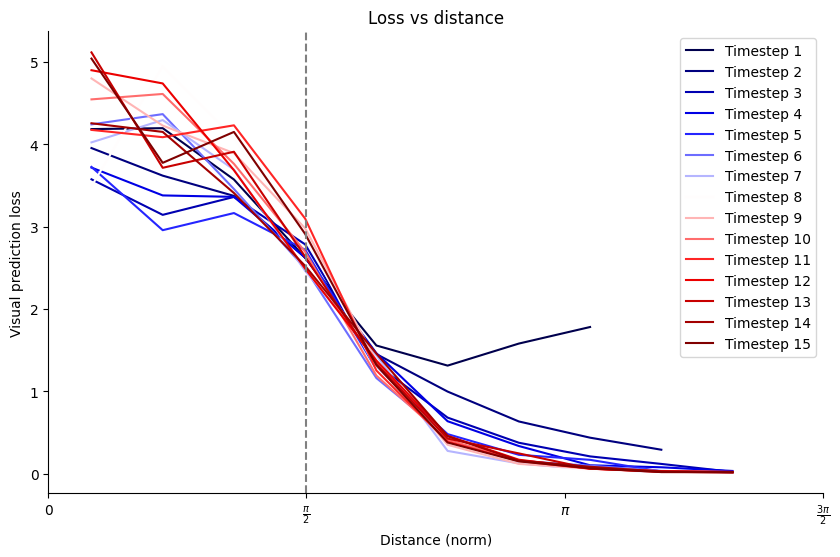

In [20]:
# l vs |pos_a-pos_dot|, v2
%matplotlib inline
# plot avg loss of visual prediction (l vs |pos_a-pos_dot|) at each timestep
loss = loss_v_arr_ # l = jnp.mean(loss_v_arr_,axis=0) # [500,6]->[6,]
dis_rel = mod_(pos_arr - dot_arr)
dis_norm = jnp.linalg.norm(dis_rel,axis=1,ord=2)[:,1:] # d = jnp.mean(jnp.abs(pos_arr - dot_arr),axis=0)[:,-1] # [500,2,7]->[2,7]
STEPS = loss_v_arr_.shape[1]
# bin distance norms
num_bins = 10
bin_edges = jnp.linspace(jnp.min(dis_norm), jnp.max(dis_norm), num_bins+1)
bin_indices = jnp.digitize(dis_norm, bin_edges)
# group losses for each timestep,bin
bin_means = jnp.zeros((num_bins, STEPS))
for i in range(STEPS):  # for each timestep
    for j in range(num_bins):  # for each bin
        mask = (bin_indices[:, i] == j + 1)  # +1 because digitize returns 1-based binning
        bin_means = bin_means.at[j, i].set(jnp.mean(loss[mask, i]))
# plot
fig,ax = plt.subplots(figsize=(10,6))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
cmap = cm.seismic(jnp.linspace(0, 1, STEPS))
for i in jnp.arange(0,STEPS,1): # ,3
    plt.plot(bin_centers, bin_means[:, i],color=cmap[i], label=f'Timestep {i+1}')
plt.axvline(x=(np.pi/2), color='grey', linestyle='--') #, label='aperture')  # Adding the vertical line
plt.title("Loss vs distance")
plt.xlabel("Distance (norm)")
plt.ylabel("Visual prediction loss")
ticks = [0, np.pi/2, np.pi, 3*np.pi/2]
labels = ['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$']
plt.xticks(ticks, labels)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend()
plt.show()


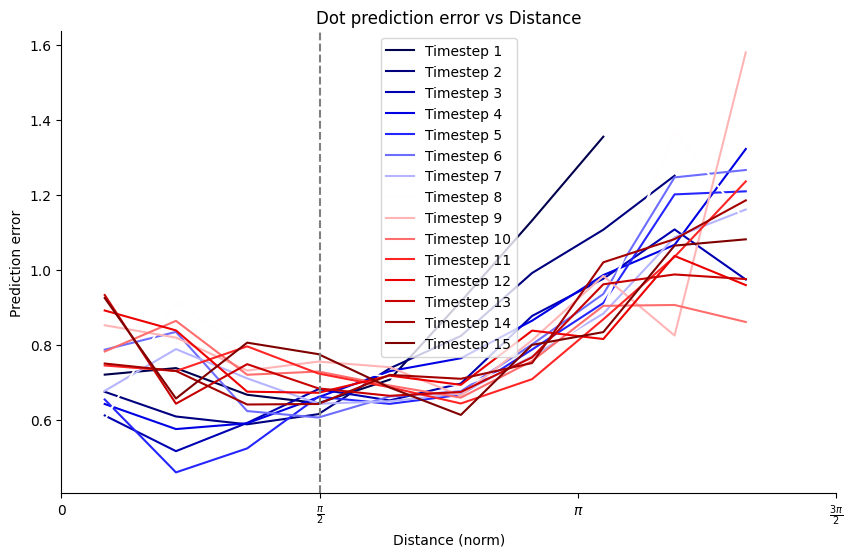

In [21]:
# |pos_dot^-pos_dot| vs |pos_a-pos_dot|, v2
%matplotlib inline

# plot avg distance of dot prediction (|pos_dot^-pos_dot| vs |pos_a-pos_dot|) at each timestep
dis_rel = mod_(pos_arr - dot_arr)
dis_norm = jnp.linalg.norm(dis_rel,axis=1,ord=2)[:,1:] # [15]
dot_hat_arr = rel_vec_hat_arr.transpose(0,2,1)[:,:,1:] + pos_arr[:,:,1:] # [500,2,15]
dot_rel = mod_(dot_hat_arr - dot_arr[:,:,1:])
dot_norm = jnp.linalg.norm(dot_rel,axis=1,ord=2)
STEPS = loss_v_arr_.shape[1]

# bin distance norms
num_bins = 10
bin_edges = jnp.linspace(jnp.min(dis_norm), jnp.max(dis_norm), num_bins+1)
bin_indices = jnp.digitize(dis_norm, bin_edges)

# group losses for each timestep,bin
bin_means = jnp.zeros((num_bins, STEPS))
for i in range(STEPS):  # for each timestep
    for j in range(num_bins):  # for each bin
        mask = (bin_indices[:, i] == j + 1)  # +1 because digitize returns 1-based binning
        bin_means = bin_means.at[j, i].set(jnp.mean(dot_norm[mask, i]))

# plot
fig,ax = plt.subplots(figsize=(10,6))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
cmap = cm.seismic(jnp.linspace(0, 1, STEPS))
for i in range(STEPS):
    plt.plot(bin_centers, bin_means[:, i], color=cmap[i],label=f'Timestep {i+1}')
plt.axvline(x=np.pi/2, color='grey', linestyle='--') #, label='aperture')  # Adding the vertical line
plt.title("Dot prediction error vs Distance")
plt.xlabel("Distance (norm)")
plt.ylabel("Prediction error")
ticks = [0, np.pi/2, np.pi, 3*np.pi/2]
labels = ['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$']
plt.xticks(ticks, labels)
plt.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

trial_loss= (15,) [2.1568727  3.3148031  1.7951465  3.0938892  4.236104   1.5751218  0.0475675  0.01639396 0.02633899 0.20868772 2.37504    5.167788   2.7370021  3.0302556  1.8487208 ]
dis_norm_trial= (15,) [0.40666673 0.2464029  0.2596683  0.7641156  1.7881247  2.8665788  3.762945   3.745823   3.034902   2.50046    1.9913093  1.0279361  0.5961062  0.7609206  0.776146  ]


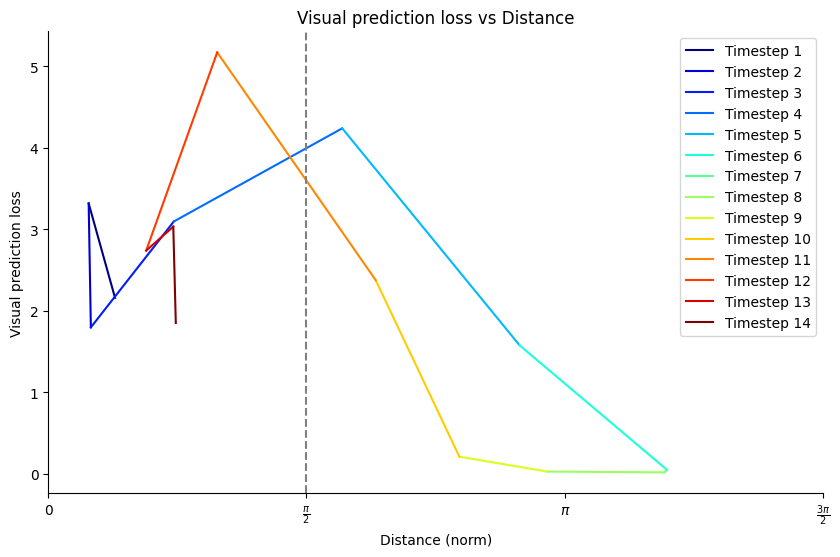

In [22]:
# single trial loss, v2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

k = 0 # 0 
trial_loss = loss_v_arr_[k, :] # [500,15]->[15]
print('trial_loss=',trial_loss.shape, trial_loss)
dis_rel_trial = mod_(pos_arr[k,:,1:] - dot_arr[k,:,1:]) # [500,2,16]
dis_norm_trial = np.linalg.norm(dis_rel_trial, axis=0, ord=2) # [15]
print('dis_norm_trial=',dis_norm_trial.shape, dis_norm_trial)

# Create a colormap based on the timestep
colors = cm.jet(np.linspace(0, 1, len(trial_loss)-1))

fig, ax = plt.subplots(figsize=(10, 6))
for i in range(len(trial_loss) - 1):
    ax.plot(dis_norm_trial[i:i+2], trial_loss[i:i+2], color=colors[i], label=f'Timestep {i+1}')

plt.axvline(x=np.pi/2, color='grey', linestyle='--') #, label='aperture')  # Adding the vertical line
plt.title("Visual prediction loss vs Distance")
plt.xlabel("Distance (norm)")
plt.ylabel("Visual prediction loss")
ticks = [0, np.pi/2, np.pi, 3*np.pi/2]
labels = ['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$']
plt.xticks(ticks, labels)
plt.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()


dot_norm_trial= (15,) [0.28459156 0.56269    0.03847573 0.5399476  1.0350604  1.0535816  1.209862   1.3800495  1.2799846  0.7060281  0.54155403 1.1440424  0.51013017 0.50707984 0.13982336]
dis_norm_trial= (15,) [0.40666673 0.2464029  0.2596683  0.7641156  1.7881247  2.8665788  3.762945   3.745823   3.034902   2.50046    1.9913093  1.0279361  0.5961062  0.7609206  0.776146  ]


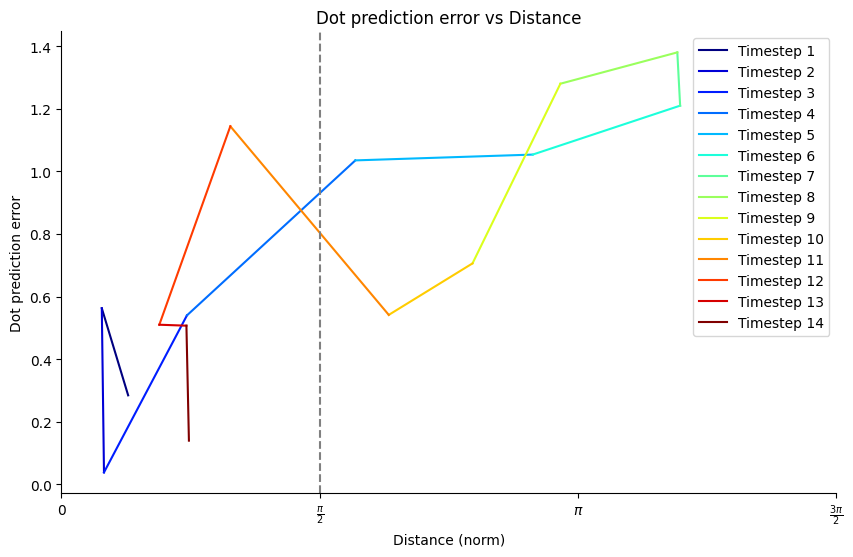

In [23]:
# single trial error, v2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

k = 0  # for example
dot_hat_arr_trial = rel_vec_hat_arr.transpose(0,2,1)[k,:,1:] + pos_arr[k,:,1:]
dot_rel_trial = mod_(dot_hat_arr_trial - dot_arr[k,:,1:])
dot_norm_trial = jnp.linalg.norm(dot_rel_trial,axis=0,ord=2)
print('dot_norm_trial=', dot_norm_trial.shape, dot_norm_trial)
dis_rel_trial = mod_(pos_arr[k,:,1:] - dot_arr[k,:,1:])
dis_norm_trial = jnp.linalg.norm(dis_rel_trial,axis=0,ord=2) # [15]
print('dis_norm_trial=', dis_norm_trial.shape, dis_norm_trial)
STEPS = loss_v_arr_.shape[1]

colors = cm.jet(np.linspace(0, 1, len(dot_norm_trial)-1))
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(len(dot_norm_trial) - 1):
    ax.plot(dis_norm_trial[i:i+2], dot_norm_trial[i:i+2], color=colors[i], label=f'Timestep {i+1}')

plt.title("Dot prediction error vs distance for a single trial")
plt.axvline(x=np.pi/2, color='grey', linestyle='--') #, label='aperture')  # Adding the vertical line
plt.title("Dot prediction error vs Distance")
plt.xlabel("Distance (norm)")
plt.ylabel("Dot prediction error")
ticks = [0, np.pi/2, np.pi, 3*np.pi/2]
labels = ['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$']
plt.xticks(ticks, labels)
plt.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

In [ ]:
# (test ani)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.gridspec import GridSpec

# Create the main figure
# Keeping the width and height ratio in mind, using 6x8 ensures square subplots
fig = plt.figure(figsize=(6, 8))

# Create a GridSpec layout with 3 rows and 2 columns
gs = GridSpec(3, 2, figure=fig)

# Using the GridSpec layout, add three subplots
ax1 = fig.add_subplot(gs[0:2, :])  # Top square subplot spans first two rows and both columns
ax2 = fig.add_subplot(gs[2, 0])    # Bottom left square subplot
ax3 = fig.add_subplot(gs[2, 1])    # Bottom right square subplot

# Sample data
x = np.linspace(0, 2 * np.pi, 100)

# Initial plots
line1, = ax1.plot(x, np.sin(x))
line2, = ax2.plot(x, np.sin(2 * x))
line3, = ax3.plot(x, np.sin(3 * x))

def update(frame):
    """Update function for the animation"""
    line1.set_ydata(np.sin(x + frame * 0.1))
    line2.set_ydata(np.sin(2 * x + frame * 0.2))
    line3.set_ydata(np.sin(3 * x + frame * 0.3))
    return line1, line2, line3

# Create the animation
ani = FuncAnimation(fig, update, frames=np.arange(0, 100), blit=True)

plt.tight_layout()
plt.show()


In [ ]:
# BACKUP DONT DELETE:
# 2
%matplotlib qt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.animation as animation
import functools

def mod_(x):
    return (x + np.pi) % (2 * np.pi) - np.pi

def gen_vectors(MODULES, APERTURE):
    m = MODULES
    A = APERTURE
    x = np.linspace(-(A-A/m), (A-A/m), m)
    x_ = np.tile(x, (m, ))
    y_ = np.repeat(np.flip(x), m)
    return np.vstack([x_, y_])

def set_axis_properties(ax,lim,labels,title=''):
    ax.set_xlim(-lim,lim)
    ax.set_ylim(-lim,lim)
    ax.set_aspect('equal', 'box')  
    ax.set_title(title)
    ticks = np.linspace(-lim,lim,5)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

def animate(i, v_pred_arr, v_t_arr, dot_arr, pos_arr, dot, agent, neuron_locs, scatters_pred, scatters_t):
    # initialize
    dot.set_data(mod_(dot_arr[i, 0]), mod_(dot_arr[i, 1]))
    agent.set_data(mod_(pos_arr[i, 0]), mod_(pos_arr[i, 1]))

    # Update v_pred_arr
    scatters_pred.set_offsets(neuron_locs.T)
    scatters_pred.set_array(v_pred_arr[i,:,:].flatten())
    scatters_pred.set_sizes(17 * np.sum(v_pred_arr[i, :, :], axis=0))
    # Update v_t_arr
    scatters_t.set_offsets(neuron_locs.T)
    scatters_t.set_array(v_t_arr[i,:,:].flatten())
    scatters_t.set_sizes(17 * np.sum(v_t_arr[i, :, :], axis=0))

    return [dot, agent, scatters_pred, scatters_t]

k = 0
interval = 300
STEPS = v_pred_arr.shape[1]
MODULES = 15
NEURONS = 10
APERTURE = np.pi/5

neuron_locs = gen_vectors(NEURONS, APERTURE)
v_pred_arr_ = np.clip(v_pred_arr[k,:,:],0,1).reshape((STEPS,3,NEURONS**2)) #.transpose(0, 2, 1)
v_t_arr_ = v_t_arr[k,:,:].reshape((STEPS,3,NEURONS**2)) #.transpose(0, 2, 1)
dot_arr_ = dot_arr[k,:,:-1].T
pos_arr_ = pos_arr[k,:,:-1].T

fig = plt.figure(figsize=(10, 15))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1])

ax_ani = plt.subplot(gs[0:2, 0:2],aspect='equal')
dot, = ax_ani.plot(mod_(dot_arr[0, 0]), mod_(dot_arr[0, 1]), 'rx')
agent, = ax_ani.plot(mod_(pos_arr[0, 0]), mod_(pos_arr[0, 1]), 'k+')
set_axis_properties(ax_ani,jnp.pi,["$-\pi$", "$-\pi/2$", "0", "$\pi/2$", "$\pi$"])

ax_pred = plt.subplot(gs[2, 0],aspect='equal')
scatters_pred = ax_pred.scatter(neuron_locs[0, :], neuron_locs[1, :], c=v_pred_arr_[0, :, :].T, s=17 * np.sum(v_pred_arr_[0, :, :], axis=0), marker='o')
set_axis_properties(ax_pred,APERTURE,["$-\pi/5$", "$-\pi/10$", "0", "$\pi/10$", "$\pi/5$"],'v_pred')

ax_t = plt.subplot(gs[2, 1],aspect='equal')
scatters_t = ax_t.scatter(neuron_locs[0, :], neuron_locs[1, :], c=v_t_arr_[0, :, :].T, s=17 * np.sum(v_t_arr_[0, :, :], axis=0), marker='o')
set_axis_properties(ax_t,APERTURE,["$-\pi/5$", "$-\pi/10$", "0", "$\pi/10$", "$\pi/5$"],'v_t')

partial_animate = functools.partial(
    animate,
    v_pred_arr=v_pred_arr_, 
    v_t_arr=v_t_arr_, 
    dot_arr=dot_arr_, 
    pos_arr=pos_arr_, 
    dot=dot, 
    agent=agent, 
    neuron_locs=neuron_locs, 
    scatters_pred=scatters_pred, 
    scatters_t=scatters_t
)

ani = animation.FuncAnimation(
    fig=fig, 
    func=partial_animate,
    frames=STEPS, 
    blit=True, 
    interval=interval
)

plt.tight_layout()
plt.show()